<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/energy_model_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

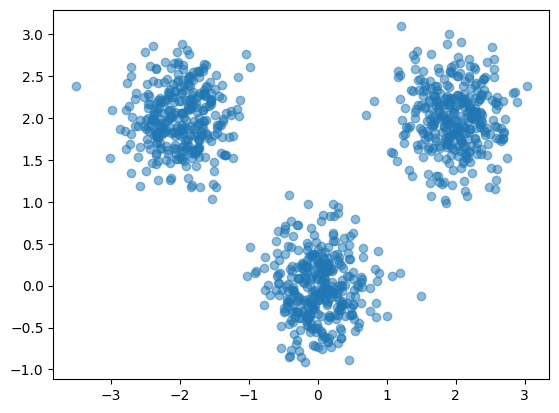

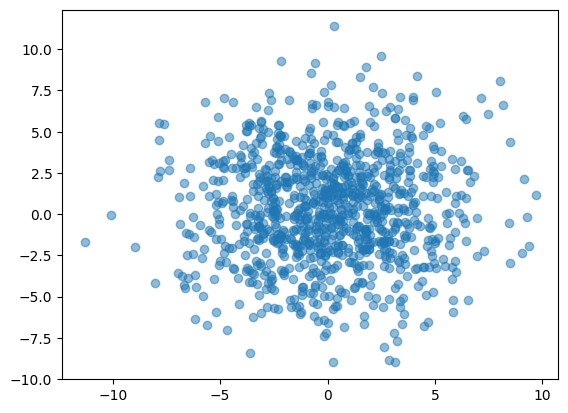

In [27]:
#@title Generate 2D GMM Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def generate_2d_gmm_dataset(num_samples=1000):
    # Define the GMM parameters
    means = torch.tensor([[0.0, 0.0], [2.0, 2.0], [-2.0, 2.0]])
    covariances = torch.stack([torch.eye(2) * 0.5, torch.eye(2) * 0.5, torch.eye(2) * 0.5]) * 0.1 + 0.1 * torch.eye(2)
    dist = torch.distributions.MixtureSameFamily(
        torch.distributions.Categorical(torch.tensor([0.33, 0.33, 0.33])),
        torch.distributions.MultivariateNormal(means, covariances)
    )

    data = dist.sample((num_samples,))
    return data, dist

# Generate the dataset
data, dist = generate_2d_gmm_dataset()
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.show()

proposal = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2) * 10)

data_proposal = proposal.sample((1000,))
plt.scatter(data_proposal[:, 0], data_proposal[:, 1], alpha=0.5)
plt.show()

logZ: 8.63


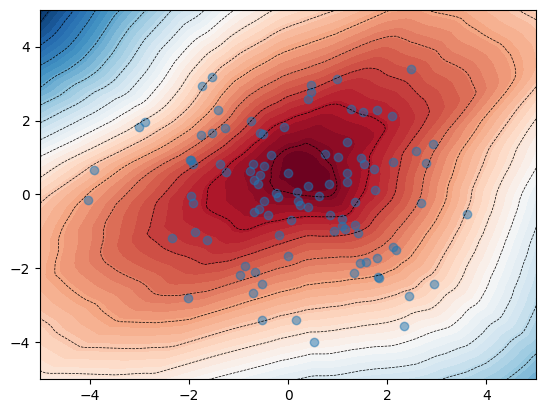

In [28]:
#@title Define Energy Model

import math

class EnergyModel(nn.Module):
    def __init__(self, logp_model):
        super(EnergyModel, self).__init__()
        self.logp = logp_model  # (unnormalized) log-probability density function, or the negative energy

    def forward(self, x):
        return self.logp(x)

    def get_energy_on_grid(self, x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y = torch.meshgrid(x_range, y_range, indexing='ij')
        input_grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # Reshape to (N, dim)
        Z = self(input_grid).reshape(X.shape)
        return X, Y, Z

    # Generate a grid of input values
    def plot_energy_contour(self):

        # Evaluate the model on the grid
        with torch.no_grad():
            X,Y,Z = self.get_energy_on_grid()
        plt.contour(X.cpu(), Y.cpu(), Z.cpu(), levels=14, linewidths=0.5, colors='k')
        plt.contourf(X.cpu(), Y.cpu(), Z.cpu(), levels=50, cmap='RdBu_r')

    def logZ_by_grid(self,  x_range=torch.linspace(-5, 5, 100), y_range=torch.linspace(-5, 5, 100)):
        X, Y, Z = self.get_energy_on_grid(x_range=x_range, y_range=y_range)
        logZ = torch.logsumexp(Z.flatten(), dim=0) # correct upto a constant
        return logZ

    def langevin_sampler(self, x0,  num_steps=100, step_size=0.01):
        # langevin sampler for energy model
        x = x0.clone().detach().requires_grad_(True)  # Ensure x requires grad for sampling
        for iter in range(num_steps):
          grad_energy = torch.autograd.grad(self(x).sum(), x)[0]
          x = x + .5*step_size * grad_energy + torch.randn_like(x) * math.sqrt(2 * step_size)
        return x

    @torch.no_grad()
    def importance_sampler(self, num_samples, proposal):
        data_proposal = proposal.sample((num_samples,))
        log_wts =  energy_model.logp(data_proposal).squeeze() - proposal.log_prob(data_proposal).squeeze()
        wts = torch.softmax(log_wts[:,None],dim = 0).squeeze()
        return data_proposal.detach(), wts.detach()

mlp = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
model = EnergyModel(mlp)

model.plot_energy_contour()

logZ = model.logZ_by_grid()

print(f'logZ:{logZ: .2f}')

x0 = torch.randn((100,2))
x = model.langevin_sampler(x0,  num_steps=100, step_size=0.01).detach()
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.show()

<Figure size 640x480 with 0 Axes>

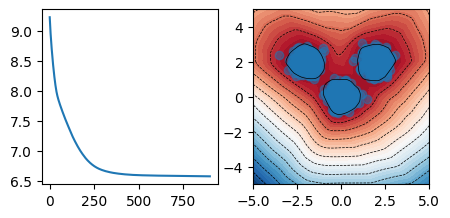

<Figure size 640x480 with 0 Axes>

In [29]:
#@title Training: logZ calculated by brute force
mlp = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
energy_model = EnergyModel(mlp)

batch_size = 1000
optimizer = optim.Adam(energy_model.parameters(), lr=1e-3)

from IPython.display import clear_output

loss_curve = []
for iter in range(1000):

  optimizer.zero_grad()
  data_real = data[torch.randperm(len(data))[:batch_size]]

  loss =  -(torch.mean(energy_model(data_real)) - energy_model.logZ_by_grid())

  loss.backward()
  optimizer.step()

  loss_curve.append(loss.item())
  if iter % 100 == 0:
    clear_output(wait=True)

    plt.figure(figsize=(5,5))

    plt.subplot(221)
    plt.plot(loss_curve)

    plt.subplot(222)
    energy_model.plot_energy_contour()
    plt.scatter(data_real[:, 0], data_real[:, 1], alpha=0.5, label='real')

    #plt.subplot(223)
    #energy_model.plot_energy_contour()
    #x0 = torch.randn((100,2))
    #x_langevin = model.langevin_sampler(x0,  num_steps=1000, step_size=0.01).detach()
    #plt.scatter(x_langevin[:, 0], x_langevin[:, 1], alpha=0.5, label='Langevin')

    plt.show()
    plt.suptitle(f'iter={iter}')



<Figure size 640x480 with 0 Axes>

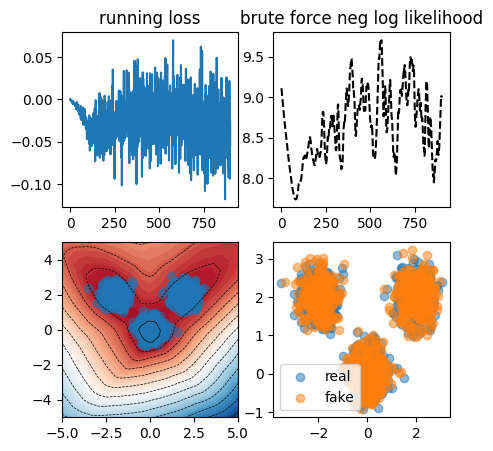

<Figure size 640x480 with 0 Axes>

In [30]:
#@title  Training with Contrastive Divergence

mlp = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
energy_model = EnergyModel(mlp)

batch_size = 1000
optimizer = optim.Adam(energy_model.parameters(), lr=1e-3)


from IPython.display import clear_output

loss_curve = []
true_neg_log_likelihood = []
for iter in range(1000):

  optimizer.zero_grad()

  data_real = data[torch.randperm(len(data))[:batch_size]]

  data_fake = energy_model.langevin_sampler(data_real, num_steps=1, step_size=0.01).detach()
  loss = -(energy_model(data_real).mean() - energy_model(data_fake).mean())
  loss.backward()
  optimizer.step()

  true_neg_log_likelihood.append(-((torch.mean(energy_model(data_real)) - energy_model.logZ_by_grid())).item())
  loss_curve.append(loss.item())
  if iter % 100 == 0:
    clear_output(wait=True)

    plt.figure(figsize=(5,5))

    plt.subplot(221)
    plt.plot(loss_curve)
    plt.title('running loss')

    plt.subplot(222)
    plt.plot(true_neg_log_likelihood, '--k')
    plt.title('brute force neg log likelihood')

    plt.subplot(223)
    energy_model.plot_energy_contour()
    plt.scatter(data_real[:, 0], data_real[:, 1], alpha=0.5, label='real')

    plt.subplot(224)
    plt.scatter(data_real[:, 0], data_real[:, 1], alpha=0.5, label='real')
    plt.scatter(data_fake[:, 0], data_fake[:, 1], alpha=0.5, label='fake')
    plt.legend()

    plt.show()
    plt.suptitle(f'iter={iter}')
